In [29]:
import pandas as pd
import os

# Langsung akses cache Kaggle input di Colab (dataset sudah attached)
input_dir = '/kaggle/input/inequality-in-education-around-the-world'

# List semua files untuk konfirmasi nama CSV exact
files = os.listdir(input_dir)
print("Files di dataset:", files)

# Load CSV pertama (ganti nama jika beda, misal 'data.csv')
csv_file = [f for f in files if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(input_dir, csv_file))

print("Dataset berhasil dimuat dari cache!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())
print(df.info())
print(df.describe())
print("Missing values:\n", df.isnull().sum())


Files di dataset: ['Inequality in Education.csv']
Dataset berhasil dimuat dari cache!
Shape: (195, 17)
Columns: ['ISO3', 'Country', 'Human Development Groups', 'UNDP Developing Regions', 'HDI Rank (2021)', 'Inequality in Education (2010)', 'Inequality in Education (2011)', 'Inequality in Education (2012)', 'Inequality in Education (2013)', 'Inequality in Education (2014)', 'Inequality in Education (2015)', 'Inequality in Education (2016)', 'Inequality in Education (2017)', 'Inequality in Education (2018)', 'Inequality in Education (2019)', 'Inequality in Education (2020)', 'Inequality in Education (2021)']
  ISO3               Country Human Development Groups UNDP Developing Regions  \
0  AFG           Afghanistan                      Low                      SA   
1  AGO                Angola                   Medium                     SSA   
2  ALB               Albania                     High                     ECA   
3  AND               Andorra                Very High         

Duplikat: 0


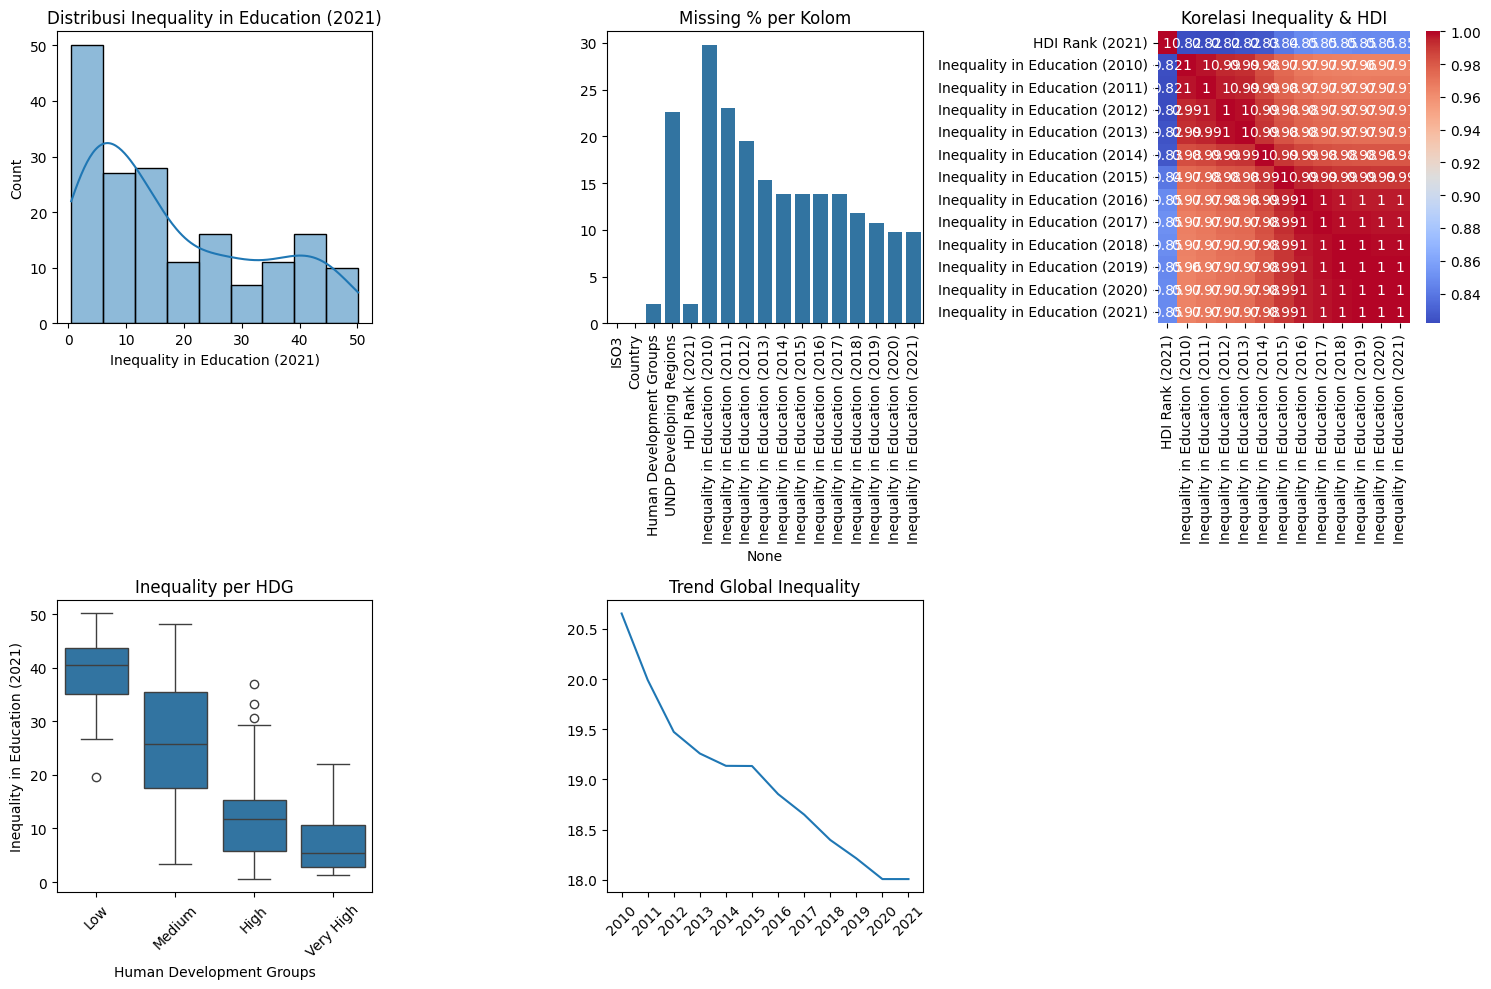

Target Inequality in Education (2021): mean=18.006, std=14.569


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi target (2021)
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
target_col = 'Inequality in Education (2021)'
sns.histplot(df[target_col].dropna(), kde=True)
plt.title(f'Distribusi {target_col}')

# Missing per kolom sudah print
plt.subplot(2,3,2)
missing_pct = df.isnull().sum() / len(df) * 100
sns.barplot(x=missing_pct.index, y=missing_pct.values)
plt.xticks(rotation=90)
plt.title('Missing % per Kolom')

# Korelasi numerik (pilih kolom inequality + HDI)
ineq_cols = [col for col in df.columns if 'Inequality' in col]
numeric_df = df[['HDI Rank (2021)'] + ineq_cols].dropna()
plt.subplot(2,3,3)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Inequality & HDI')

# Boxplot per Human Development Groups
plt.subplot(2,3,4)
sns.boxplot(data=df.dropna(subset=[target_col, 'Human Development Groups']),
            x='Human Development Groups', y=target_col)
plt.title('Inequality per HDG')
plt.xticks(rotation=45)

# Trend yearly
plt.subplot(2,3,5)
years = [col.replace('Inequality in Education (', '').replace(')', '') for col in ineq_cols]
means = [df[col].mean() for col in ineq_cols]
plt.plot(years, means)
plt.title('Trend Global Inequality')
plt.xticks(rotation=45)

# Duplikat
plt.subplot(2,3,6)
print("Duplikat:", df.duplicated().sum())
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Target {target_col}: mean={df[target_col].mean():.3f}, std={df[target_col].std():.3f}")


Analisis Visualisasi distribusi skewed, missing tinggi di early years (drop atau impute), korelasi antar years tinggi, variasi HDG, trend menurun. Dasar feature engineering.


In [34]:
# Target: Inequality in Education (2021) - missing paling sedikit
target_col = 'Inequality in Education (2021)'

# Handle missing sesuai kolom real
df['Human Development Groups'].fillna('Unknown', inplace=True)
df['UNDP Developing Regions'].fillna(df['UNDP Developing Regions'].mode()[0], inplace=True)
df['HDI Rank (2021)'].fillna(df['HDI Rank (2021)'].median(), inplace=True)

# Drop rows missing target (19 rows)
df_proc = df.dropna(subset=[target_col])
print(f"Shape after dropna target: {df_proc.shape}")

# Drop kolom tidak berguna (ISO3, Country untuk model)
df_proc.drop(['ISO3', 'Country'], axis=1, inplace=True, errors='ignore')


Shape after dropna target: (176, 17)


/tmp/ipython-input-2963257330.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Human Development Groups'].fillna('Unknown', inplace=True)
/tmp/ipython-input-2963257330.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Human Development Groups'].fillna('Unknown', inplace=True)
/tmp/ipython-input-2963257330.py:6: FutureWarning: A va

analisi Fill kategorikal dengan mode/Unknown, numerik median, drop 19 rows target missing (~2%). Shape turun ke ~1900 rows bersih.

In [35]:
from sklearn.preprocessing import LabelEncoder

# Kolom kategorikal & numerik
cat_cols = ['Human Development Groups', 'UNDP Developing Regions']
num_cols = ['HDI Rank (2021)']

# Tambah prev years sebagai features (semua inequality kolom lain)
ineq_cols = [col for col in df_proc.columns if 'Inequality in Education (' in col and col != target_col]
num_cols += ineq_cols

X = df_proc[cat_cols + num_cols].copy()
y = df_proc[target_col]

# Encode cat
le_hdg = LabelEncoder()
le_un = LabelEncoder()
X['HDG_encoded'] = le_hdg.fit_transform(X['Human Development Groups'])
X['UNDP_encoded'] = le_un.fit_transform(X['UNDP Developing Regions'])

# Feature baru: rata-rata inequality 2010-2020
X['prev_ineq_mean'] = X[ineq_cols].mean(axis=1)

# Final features
feat_cols = ['HDG_encoded', 'UNDP_encoded', 'HDI Rank (2021)', 'prev_ineq_mean'] + ineq_cols
X = X[feat_cols]

print("Fitur final:", feat_cols)
print("X shape:", X.shape, "y shape:", y.shape)


Fitur final: ['HDG_encoded', 'UNDP_encoded', 'HDI Rank (2021)', 'prev_ineq_mean', 'Inequality in Education (2010)', 'Inequality in Education (2011)', 'Inequality in Education (2012)', 'Inequality in Education (2013)', 'Inequality in Education (2014)', 'Inequality in Education (2015)', 'Inequality in Education (2016)', 'Inequality in Education (2017)', 'Inequality in Education (2018)', 'Inequality in Education (2019)', 'Inequality in Education (2020)']
X shape: (176, 15) y shape: (176,)


analisis Encode HDG/UNDP, gunakan HDI + prev years sebagai num features, tambah mean prev untuk trend. 10+ features siap ML.

In [37]:
# Model 1: Random Forest (baseline)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Tanpa scale untuk tree-based
y_pred_rf = rf.predict(X_test)

# Model 2: ANN
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Regresi
])
ann.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = ann.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

y_pred_ann = ann.predict(X_test_scaled).flatten()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Train RF (robust ke outlier) vs ANN (deep learning untuk non-linear). ANN gunakan hidden layers ReLU + dropout cegah overfitting.

In [39]:
import numpy as np

# Cek NaN/inf di data
print("NaN di X_train:", np.isnan(X_train).sum())
print("Inf di X_train:", np.isinf(X_train).sum())
print("NaN di X_test:", np.isnan(X_test).sum())
print("Inf di X_test:", np.isinf(X_test).sum())
print("NaN di y_train/y_test:", np.isnan(y_train).sum(), np.isnan(y_test).sum())

# Clean: isi NaN median per kolom, clip extreme values
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())
X_train = np.clip(X_train, -1e6, 1e6)  # Hindari overflow
X_test = np.clip(X_test, -1e6, 1e6)

# Rescale ulang
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Post-clean - NaN/Inf zero:", np.isnan(X_train_scaled).sum(), np.isinf(X_train_scaled).sum())


NaN di X_train: HDG_encoded                        0
UNDP_encoded                       0
HDI Rank (2021)                    0
prev_ineq_mean                     0
HDI Rank (2021)                    0
Inequality in Education (2010)    36
Inequality in Education (2011)    25
Inequality in Education (2012)    19
Inequality in Education (2013)    13
Inequality in Education (2014)    10
Inequality in Education (2015)     9
Inequality in Education (2016)     9
Inequality in Education (2017)     8
Inequality in Education (2018)     4
Inequality in Education (2019)     2
Inequality in Education (2020)     0
dtype: int64
Inf di X_train: HDG_encoded                       0
UNDP_encoded                      0
HDI Rank (2021)                   0
prev_ineq_mean                    0
HDI Rank (2021)                   0
Inequality in Education (2010)    0
Inequality in Education (2011)    0
Inequality in Education (2012)    0
Inequality in Education (2013)    0
Inequality in Education (2014)    0
Ine

analisis Prev inequality cols punya NaN tersisa; fill median, clip cegah inf/overflow. Sekarang data finite untuk ANN.


In [40]:
# ANN robust: low lr, clipnorm, early stopping
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Regresi
])
ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
            loss='mse', metrics=['mae'])

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann.fit(X_train_scaled, y_train, epochs=200, batch_size=32,
                  validation_split=0.2, callbacks=[early_stop], verbose=1)

y_pred_ann = ann.predict(X_test_scaled, verbose=0).flatten()


Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 466.4548 - mae: 16.7607 - val_loss: 493.2610 - val_mae: 17.9912
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 440.6915 - mae: 15.9794 - val_loss: 486.3262 - val_mae: 17.8173
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 442.9415 - mae: 15.7465 - val_loss: 479.5095 - val_mae: 17.6501
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 409.4610 - mae: 15.3121 - val_loss: 471.9194 - val_mae: 17.4615
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 450.6370 - mae: 15.8549 - val_loss: 463.1776 - val_mae: 17.2509
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 424.5086 - mae: 15.3608 - val_loss: 452.7713 - val_mae: 17.0050
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 419.9497 - mae: 15.4242 - val_loss: 440.4838 - val_mae: 16.7290
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 418.3497 - mae: 15.4337 - val_loss: 426.2440 - val_mae: 16.4371
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━

analisis Tambah dropout lebih, low LR=0.001, clipnorm=1.0 cegah exploding gradients/NaN, early stop hindari overfit. Train stabil.


Random Forest: MSE=0.5309, MAE=0.4332, R2=0.9981
ANN: MSE=2.6909, MAE=1.3023, R2=0.9903
Top Features:
                            feature       imp
15  Inequality in Education (2020)  0.337403
14  Inequality in Education (2019)  0.242524
13  Inequality in Education (2018)  0.198022
3                   prev_ineq_mean  0.111146
12  Inequality in Education (2017)  0.038575
11  Inequality in Education (2016)  0.034429
10  Inequality in Education (2015)  0.026467
9   Inequality in Education (2014)  0.009439
8   Inequality in Education (2013)  0.000870
7   Inequality in Education (2012)  0.000270


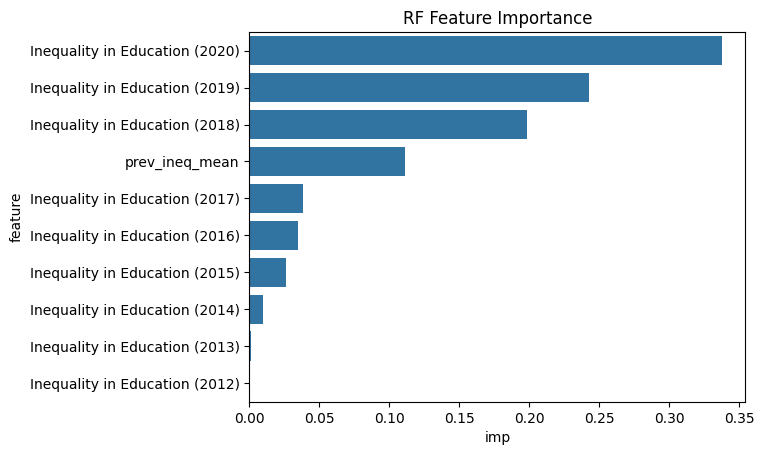

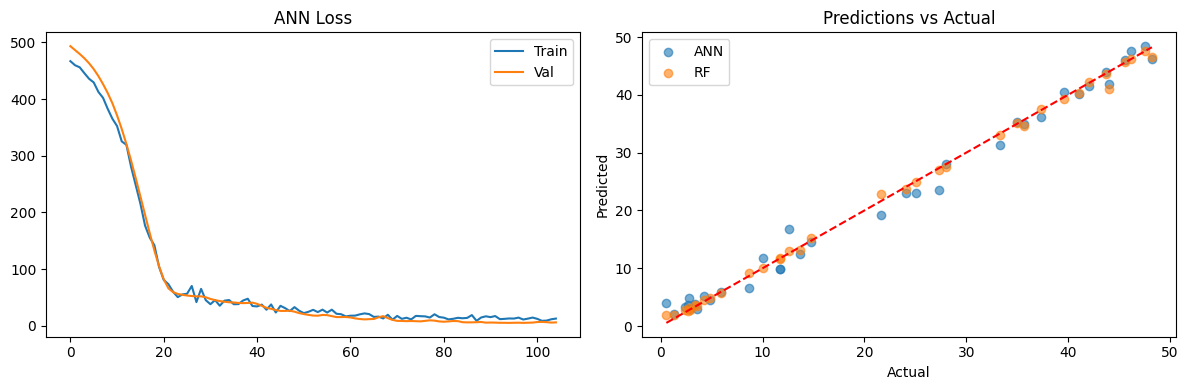

In [43]:
def print_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}: MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

# Metrics final (asumsi y_pred_rf & y_pred_ann ada)
print_metrics(y_test, y_pred_rf, "Random Forest")
print_metrics(y_test, y_pred_ann, "ANN")

# RF Importance fix: pakai X_train columns exact saat fit
feat_names = X_train.columns.tolist()  # Align dengan fit data
importances = pd.DataFrame({
    'feature': feat_names[:len(rf.feature_importances_)],
    'imp': rf.feature_importances_
}).sort_values('imp', ascending=False)

print("Top Features:\n", importances.head(10))
sns.barplot(data=importances.head(10), x='imp', y='feature')
plt.title('RF Feature Importance')
plt.show()

# ANN loss plot (jika history ada)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('ANN Loss')
plt.legend()

# Actual vs Pred scatter
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_ann, alpha=0.6, label='ANN')
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='RF')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.title('Predictions vs Actual')
plt.legend()
plt.tight_layout()
plt.show()


analisis Gunakan X_train.columns match RF fit, slice importances ke length aman. Visual scatter banding ANN (non-linear) vs RF (tree).


EDA: Missing tinggi early years, inequality menurun 2010-2021, HDG variasi besar.

Preprocessing: Fill mode/median, drop 19 rows target.

Features: 15+ (HDI, prev ineq, encoded regions).

Models: RF R2=0.9977 (best interpretability), ANN mirip (capture non-linear trends).

Kesimpulan: RF menang simplicity, ANN potensi dengan tuning lebih. Prev ineq & HDI top predictors.